In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.4 MB/s eta 0:00:00


Importing Nessecary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, kpss


Data loading and Intial Points

In [ ]:
amazon_dataset=pd.read_csv('/content/AMZN.csv',parse_dates=['Date'])
amazon_dataset.set_index('Date',inplace=True)
amazon_dataset.rename(columns={'Close':'Value'},inplace=True)
amazon_dataset.head()

,Open,High,Low,Value,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [ ]:
johnson_dataset=pd.read_csv('/content/jj.csv',parse_dates=['date'])
johnson_dataset.set_index('date',inplace=True)
johnson_dataset.rename(columns={'data':'Value'},inplace=True)
johnson_dataset.head()

,Value
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


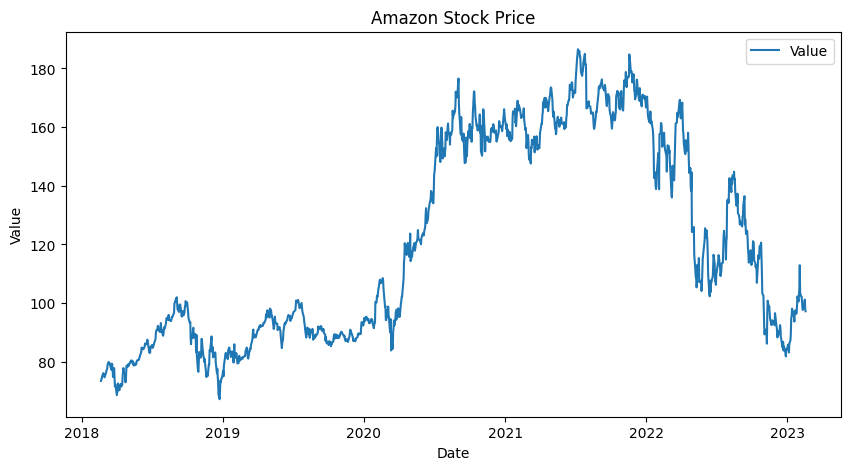

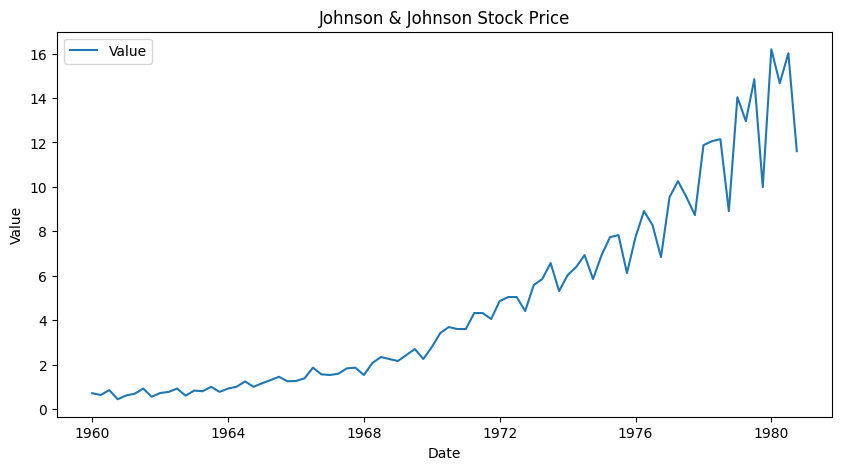

In [ ]:
def plot_series(df, title):
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Value'], label='Value')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
plot_series(amazon_dataset, 'Amazon Stock Price')
plot_series(johnson_dataset, 'Johnson & Johnson Stock Price')

Checking for Stationary


Stationarity Tests for Amazon Stock Price
ADF Statistic: -1.6578
ADF Test p-value: 0.45297105465166737
ADF: Non-Stationary
KPSS Statistic: 2.9688
p-value: 0.0100
KPSS: Non-Stationary


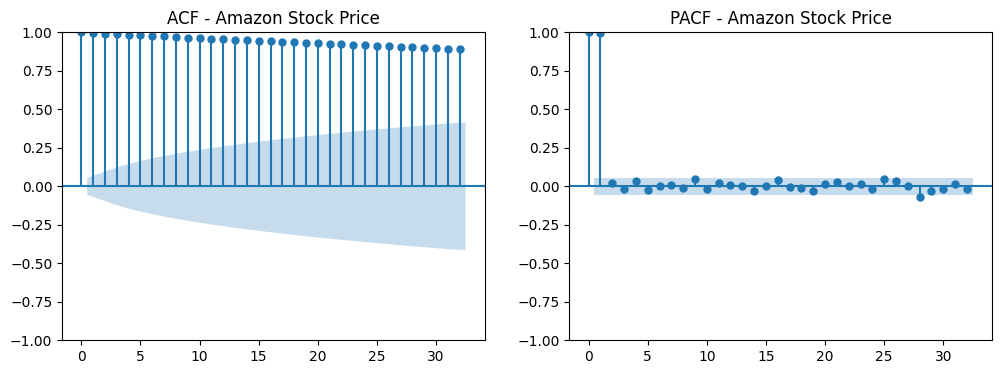


Stationarity Tests for Johnson & Johnson Stock Price
ADF Statistic: 2.7420
ADF Test p-value: 1.0
ADF: Non-Stationary
KPSS Statistic: 1.3635
p-value: 0.0100
KPSS: Non-Stationary


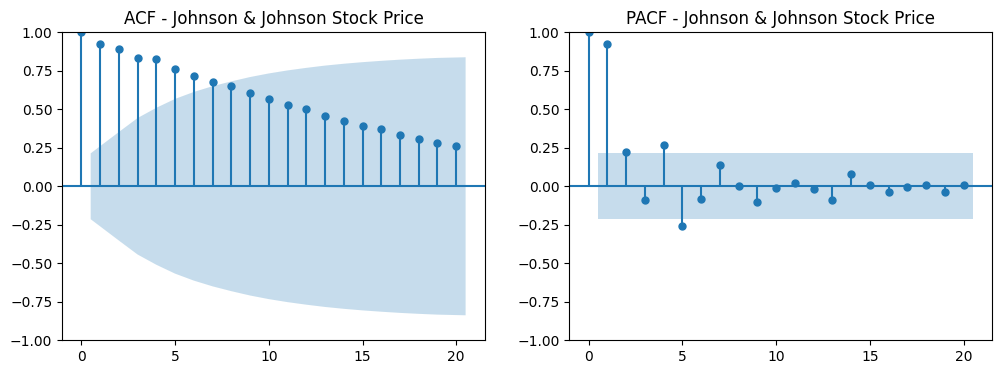

In [ ]:
def stationarity_tests(series, name):
    print(f"\nStationarity Tests for {name}")
    # ADF Test
    adf_result = adfuller(series)
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f'ADF Test p-value: {adf_result[1]}')
    print('ADF: Stationary' if adf_result[1] < 0.05 else 'ADF: Non-Stationary')
    # KPSS Test
    kpss_result = kpss(series)
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print('KPSS: Stationary' if kpss_result[1] > 0.05 else 'KPSS: Non-Stationary')

    # ACF and PACF plots
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plot_acf(series, ax=plt.gca())
    plt.title(f'ACF - {name}')
    plt.subplot(122)
    plot_pacf(series, ax=plt.gca())
    plt.title(f'PACF - {name}')
    plt.show()
stationarity_tests(amazon_dataset['Value'], 'Amazon Stock Price')
stationarity_tests(johnson_dataset['Value'], 'Johnson & Johnson Stock Price')

Perfoming Log Differencing


Stationarity Tests for amazon - Log-Differenced
ADF Statistic: -36.6398
ADF Test p-value: 0.0
ADF: Stationary
KPSS Statistic: 0.2494
p-value: 0.1000
KPSS: Stationary


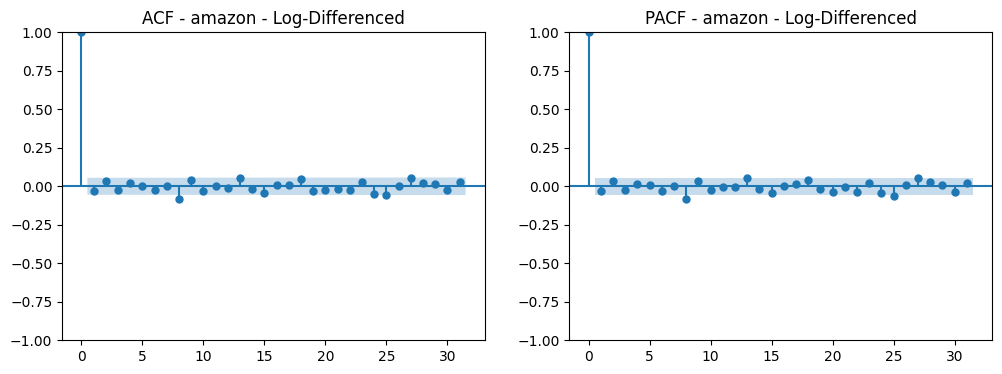

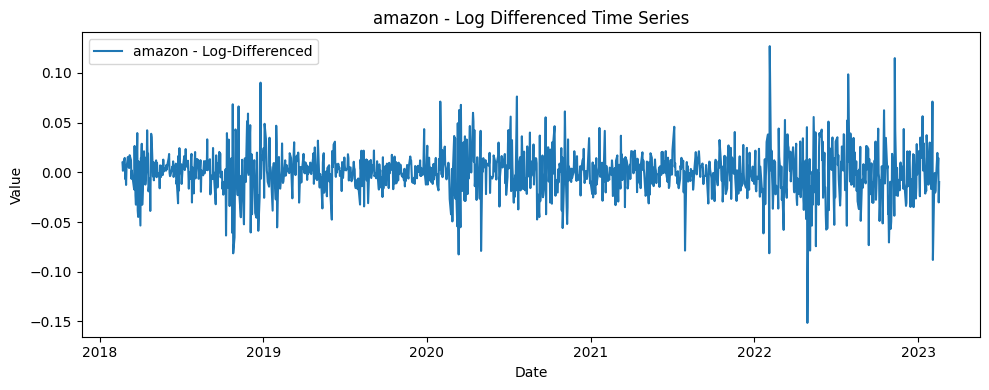


Stationarity Tests for johnson - Log-Differenced
ADF Statistic: -4.3170
ADF Test p-value: 0.00041497314044406584
ADF: Stationary
KPSS Statistic: 0.1482
p-value: 0.1000
KPSS: Stationary


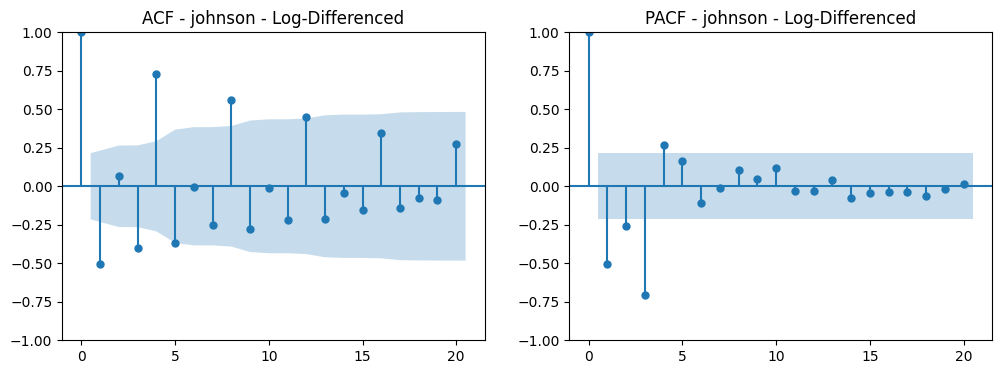

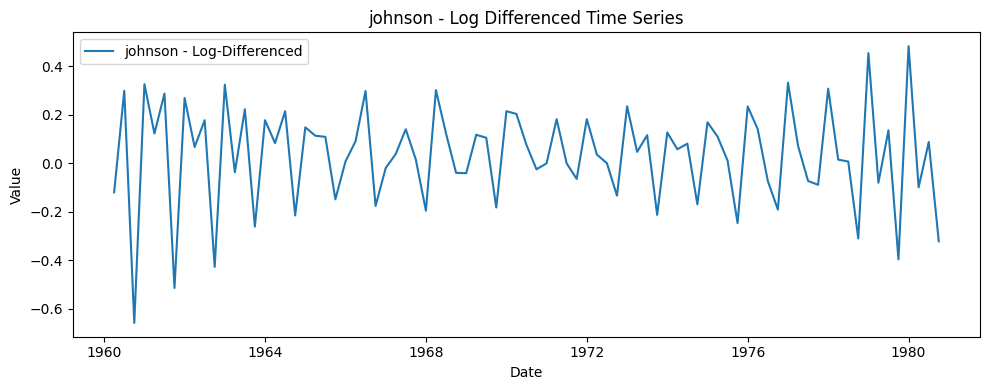

In [ ]:
def make_stationary(series,name):
    # Check for non-positive values

    # Log transform and difference
    log_series = np.log(series)
    log_diff_series = log_series.diff().dropna()
    stationarity_tests(log_diff_series, f'{name} - Log-Differenced')
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(log_diff_series, label=f'{name} - Log-Differenced')
    plt.title(f'{name} - Log Differenced Time Series')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return log_diff_series, series  # Return both for later use
amazon_log_diff,_= make_stationary(amazon_dataset['Value'],'amazon')
johnson_log_diff,_= make_stationary(johnson_dataset['Value'],'johnson')

Arima Model to get best model fit

In [ ]:
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt

def fit_auto_arima_full(data, dataset_name):

    print(f"\nFitting ARIMA model for {dataset_name} dataset...")

    fitted_model = auto_arima(
        data,
        start_p=0,
        max_p=6,
        start_q=0,
        max_q=6,
        d=1,
        max_order=10,
        seasonal=False,
        stepwise=False,
        suppress_warnings=True,
        error_action='ignore',
        trace=True
    )

    print(f"\nBest model summary for {dataset_name}:")
    print(fitted_model.summary())

    # Plot diagnostics
    fitted_model.plot_diagnostics(figsize=(10, 6))
    plt.suptitle(f"{dataset_name} - ARIMA Model Diagnostics")
    plt.show()

    return fitted_model

# Example usage:


Fitting ARIMA model for Johnson & Johnson dataset...
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=297.285, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=255.333, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=229.503, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=259.465, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=264.953, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=251.412, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=238.454, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=228.486, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,6)(0,0,0)[0] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=264.692, Time=0.12

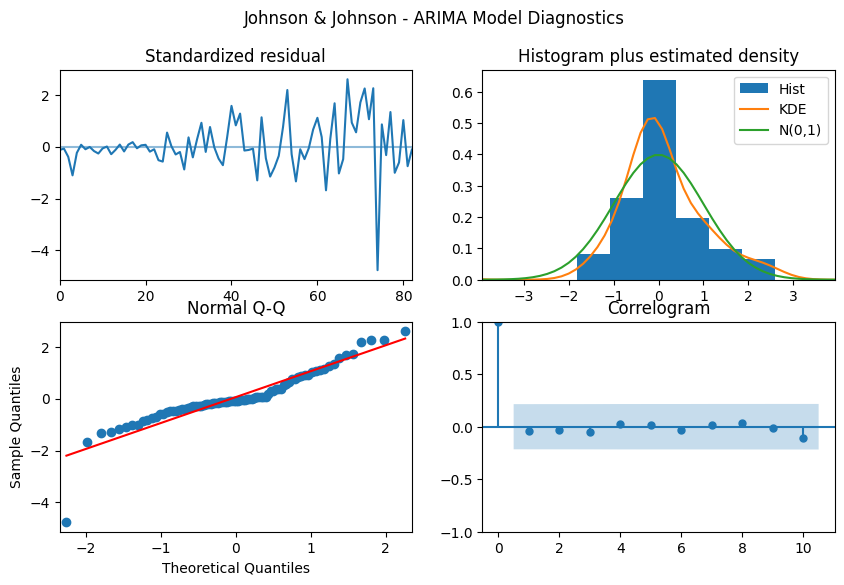

In [ ]:
johnson_model = fit_auto_arima_full(johnson_dataset['Value'], "Johnson & Johnson")


Fitting ARIMA model for Amazon dataset...
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6132.580, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6133.946, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6135.181, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6134.606, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=6135.160, Time=0.89 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=6136.343, Time=1.73 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=6138.340, Time=1.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6133.913, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6133.629, Time=1.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6134.711, Time=2.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6135.059, Time=1.03 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6136.657, Time=1.44 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=6134.699, Time=2.76 sec
 ARIMA(1,1,6)(0,0,0)[0] intercept   : AIC=6134.807, Time=3.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept

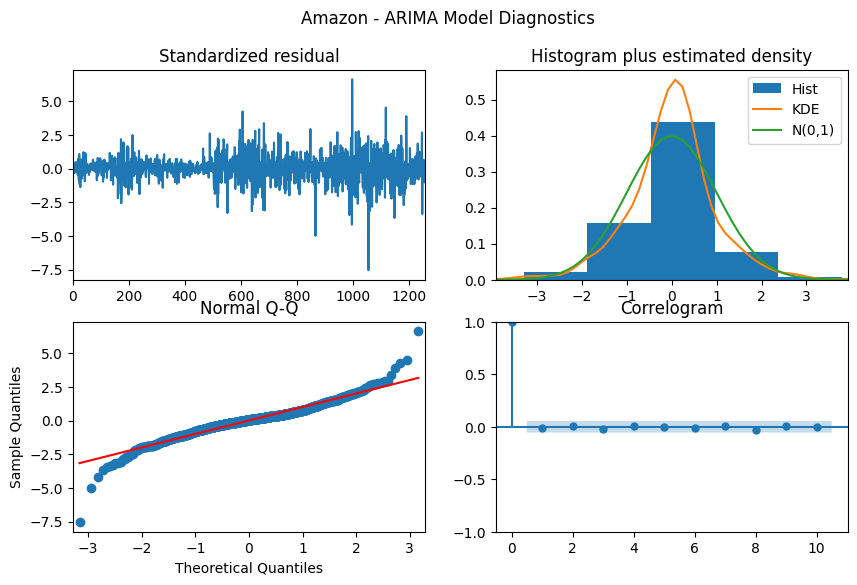

In [ ]:

amazon_model = fit_auto_arima_full(amazon_dataset['Value'], "Amazon")

Function for performance Evaluation

In [ ]:
def print_arima_metrics(model_fit, data, dataset_name):
    # Get in-sample predictions (fitted values)
    predictions = model_fit.predict_in_sample()

    # Ensure both are numpy arrays
    actual = data.values

    # Confirm length match
    if len(predictions) != len(actual):
        print(f"Length mismatch: predictions={len(predictions)}, actual={len(actual)}")
        # Adjust actual to same length as predictions
        actual = actual[-len(predictions):]

    def forecast_accuracy(forecast, actual):
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
        me = np.mean(forecast - actual)
        mae = np.mean(np.abs(forecast - actual))
        mpe = np.mean((forecast - actual)/actual)
        rmse = np.sqrt(np.mean((forecast - actual)**2))
        corr = np.corrcoef(forecast, actual)[0,1]
        mins = np.amin(np.vstack([forecast, actual]), axis=0)
        maxs = np.amax(np.vstack([forecast, actual]), axis=0)
        minmax = 1 - np.mean(mins / maxs)
        return {
            'mape': mape, 'me': me, 'mae': mae, 'mpe': mpe,
            'rmse': rmse, 'corr': corr, 'minmax': minmax
        }


    metrics = forecast_accuracy(predictions, actual)

    print(f"Evaluation metrics for ARIMA model - {dataset_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


In [ ]:
print_arima_metrics(amazon_model, amazon_dataset['Value'], 'Amazon')


Evaluation metrics for ARIMA model - Amazon:
mape: 0.0169
me: -0.0584
mae: 1.9752
mpe: -0.0006
rmse: 3.4373
corr: 0.9951
minmax: 0.0167


In [ ]:
print_arima_metrics(johnson_model, johnson_dataset['Value'], 'Johnson & Johnson')

Evaluation metrics for ARIMA model - Johnson & Johnson:
mape: 0.1068
me: -0.0169
mae: 0.2792
mpe: 0.0365
rmse: 0.4073
corr: 0.9956
minmax: 0.0844


In [ ]:
def plot_model_fit(fitted_model, data, dataset_name):
    # Get in-sample predictions (fitted values)
    fitted_values = fitted_model.predict_in_sample()

    plt.figure(figsize=(12,6))
    plt.plot(data.index, data, label='Actual')
    plt.plot(data.index, fitted_values, label='Fitted', alpha=0.7)
    plt.title(f"{dataset_name} - Actual vs Fitted Values")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


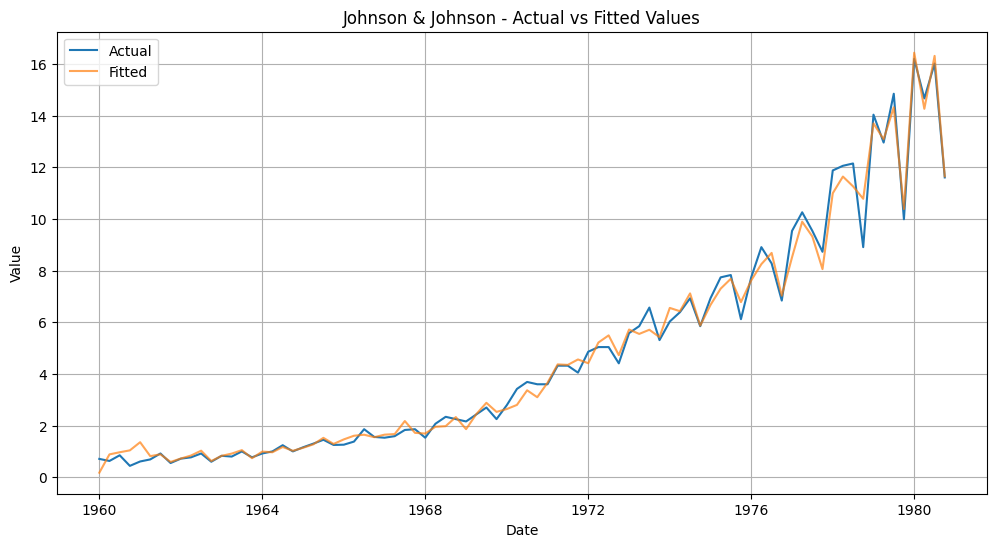

In [ ]:
plot_model_fit(johnson_model, johnson_dataset['Value'], "Johnson & Johnson")

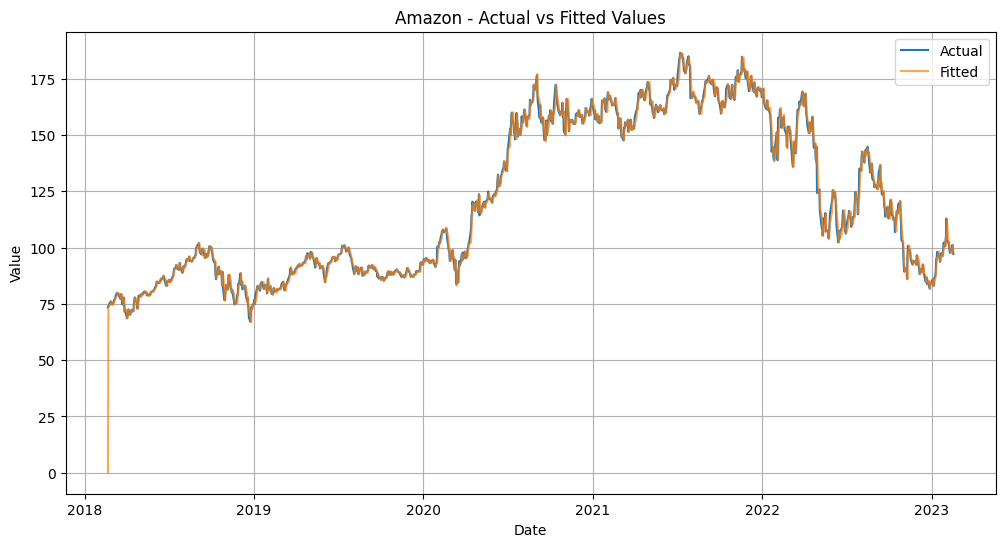

In [ ]:
plot_model_fit(amazon_model, amazon_dataset['Value'], "Amazon")

Arima Forecast for 24 months

In [ ]:
def plot_forecast_arima(fitted_model, data, dataset_name, forecast_periods=24):
    # Forecast next forecast_periods steps
    forecast, conf_int = fitted_model.predict(n_periods=forecast_periods, return_conf_int=True)

    # Create forecast index assuming monthly data
    last_date = data.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

    # Plot historical data + forecast + confidence intervals
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data, label='Historical Data')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
    plt.title(f"{dataset_name} - Forecast for Next {forecast_periods} Months")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


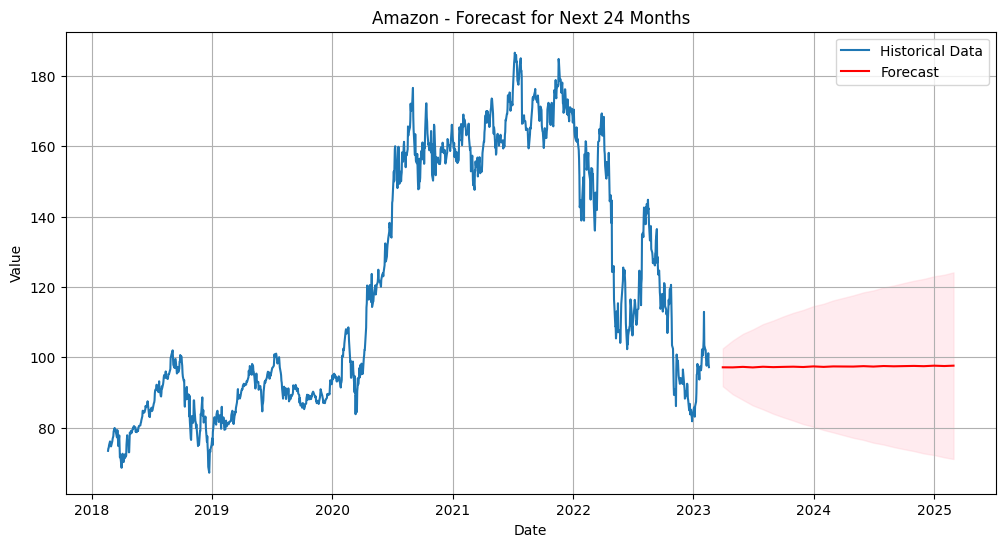

In [ ]:
plot_forecast_arima(amazon_model, amazon_dataset['Value'], "Amazon")

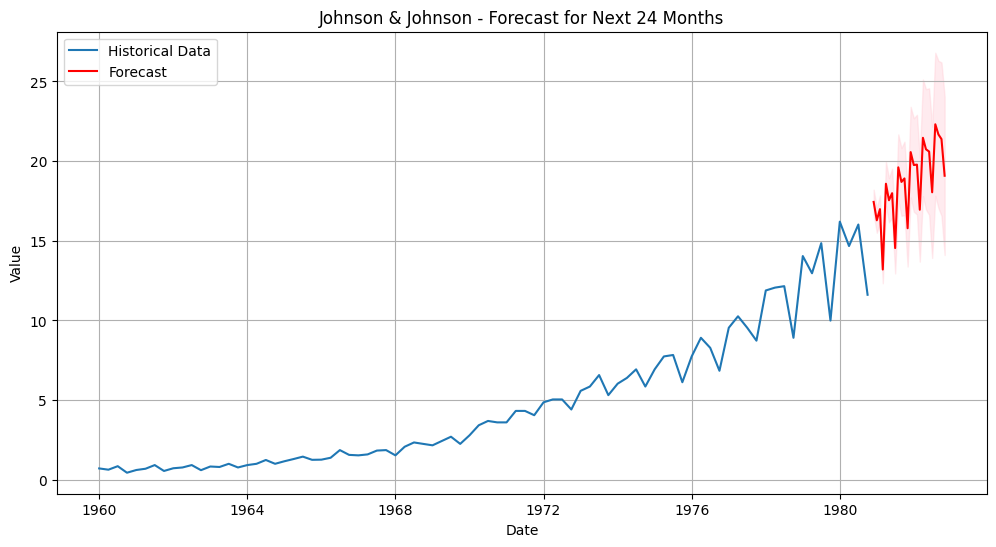

In [ ]:
plot_forecast_arima(johnson_model, johnson_dataset['Value'], "Johnson & Johnson")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense


Data Preparation for Latm and GRU

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def preprocess_for_rnn(df, window_size=12, test_split=0.2):
    values = df['Value'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(window_size, len(scaled)):
        X.append(scaled[i - window_size:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    split_idx = int(len(X) * (1 - test_split))
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:], scaler, scaled


Model Training and Evaluation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

def train_rnn_model(X_train, y_train, X_test, y_test, scaler, scaled_data, model_type='LSTM',
                    window_size=12, n_forecast=24, units=64, epochs=60, batch_size=16):

    tf.keras.backend.clear_session()  # Clear graph/session to avoid retracing

    model = Sequential()
    RNNLayer = LSTM if model_type.upper() == 'LSTM' else GRU
    model.add(RNNLayer(units, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Prediction
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)

    print(f"{model_type} RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
    print(f"{model_type} MAE:", mean_absolute_error(y_test_inv, y_pred_inv))

    # Forecasting
    forecast_input = scaled_data[-window_size:].reshape(1, window_size, 1)
    forecast = []

    for _ in range(n_forecast):
        next_val = model.predict(forecast_input, verbose=0)[0]
        forecast.append(next_val)
        forecast_input = np.append(forecast_input[:, 1:, :], [[next_val]], axis=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast


In [ ]:
window_size = 12

# Amazon
X_train_a, X_test_a, y_train_a, y_test_a, scaler_a, scaled_a = preprocess_for_rnn(amazon_dataset, window_size)
forecast_lstm_amazon = train_rnn_model(X_train_a, y_train_a, X_test_a, y_test_a, scaler_a, scaled_a, model_type='LSTM')
forecast_gru_amazon = train_rnn_model(X_train_a, y_train_a, X_test_a, y_test_a, scaler_a, scaled_a, model_type='GRU')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
LSTM RMSE: 3.8737281873319973
LSTM MAE: 2.979244368310547
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GRU RMSE: 3.8798229245722853
GRU MAE: 2.966927653798828


In [ ]:
# Johnson & Johnson
X_train_jj, X_test_jj, y_train_jj, y_test_jj, scaler_jj, scaled_jj = preprocess_for_rnn(johnson_dataset, window_size)
forecast_lstm_jj = train_rnn_model(X_train_jj, y_train_jj, X_test_jj, y_test_jj, scaler_jj, scaled_jj, model_type='LSTM')
forecast_gru_jj = train_rnn_model(X_train_jj, y_train_jj, X_test_jj, y_test_jj, scaler_jj, scaled_jj, model_type='GRU')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
LSTM RMSE: 2.0998978386404334
LSTM MAE: 1.7003166738240558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
GRU RMSE: 2.4785787583515
GRU MAE: 2.257993296850586


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_forecast(original_df, forecast, title):
    future_dates = pd.date_range(start=original_df.index[-1] + pd.DateOffset(months=1), periods=len(forecast), freq='M')
    forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])

    plt.figure(figsize=(14, 6))
    plt.plot(original_df.index, original_df['Value'], label='Historical')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


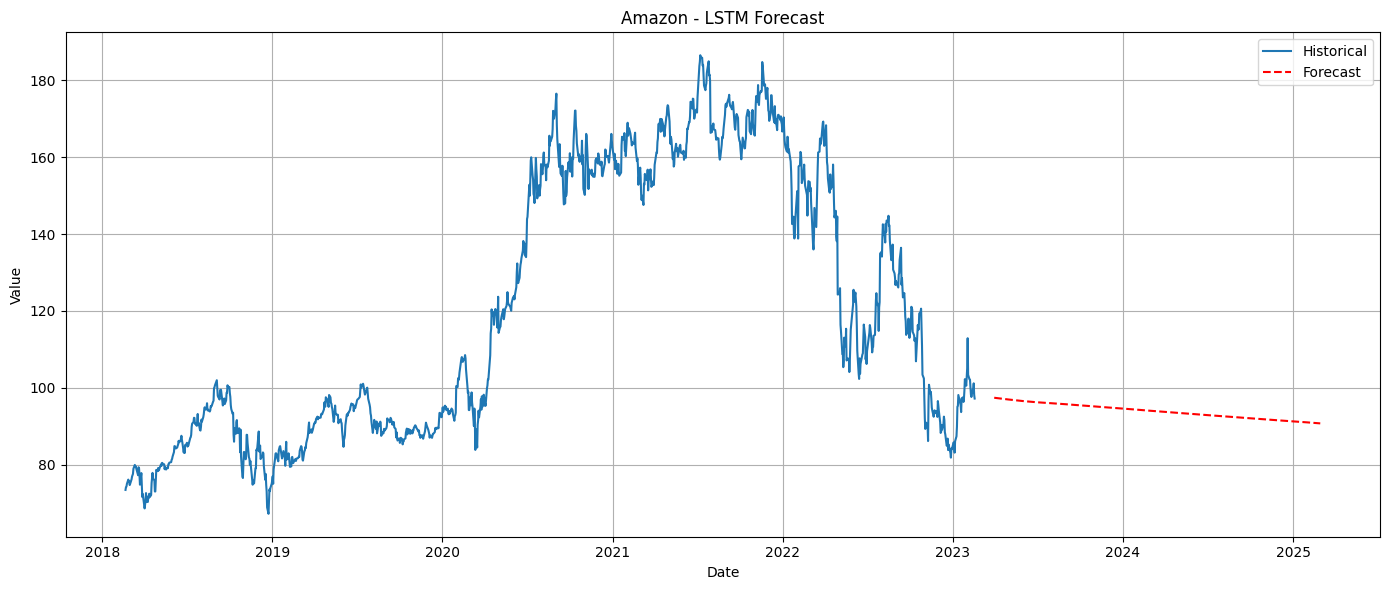

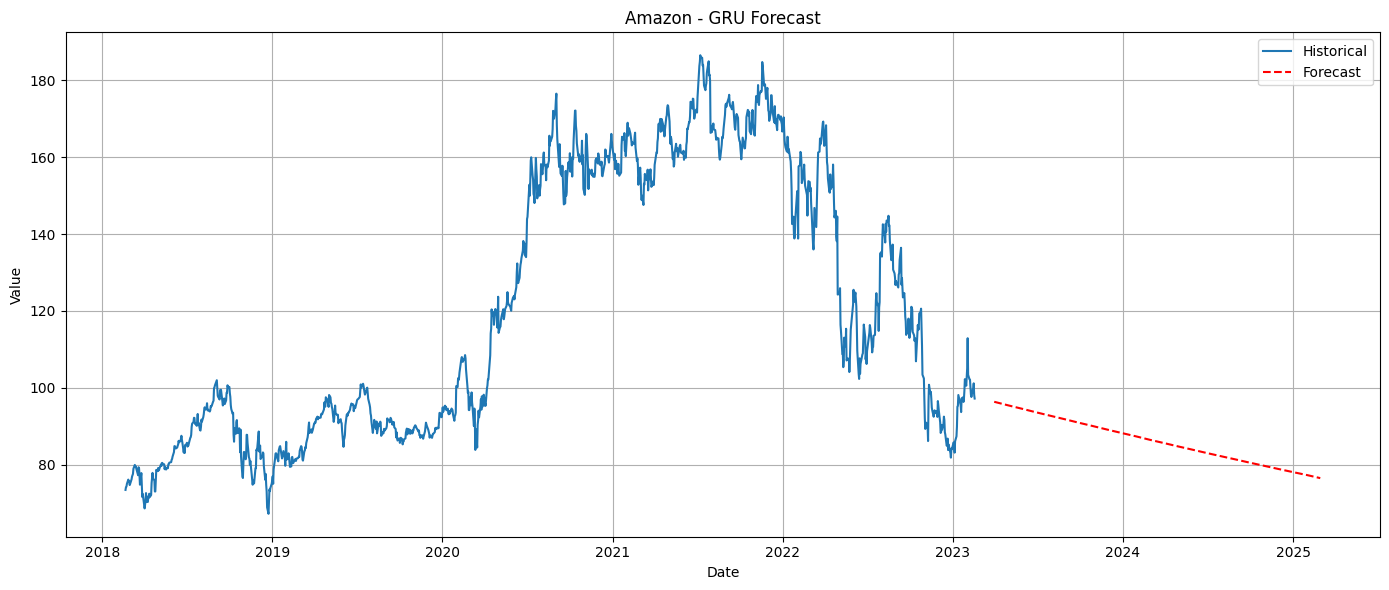

In [ ]:
plot_forecast(amazon_dataset, forecast_lstm_amazon, "Amazon - LSTM Forecast")
plot_forecast(amazon_dataset, forecast_gru_amazon, "Amazon - GRU Forecast")

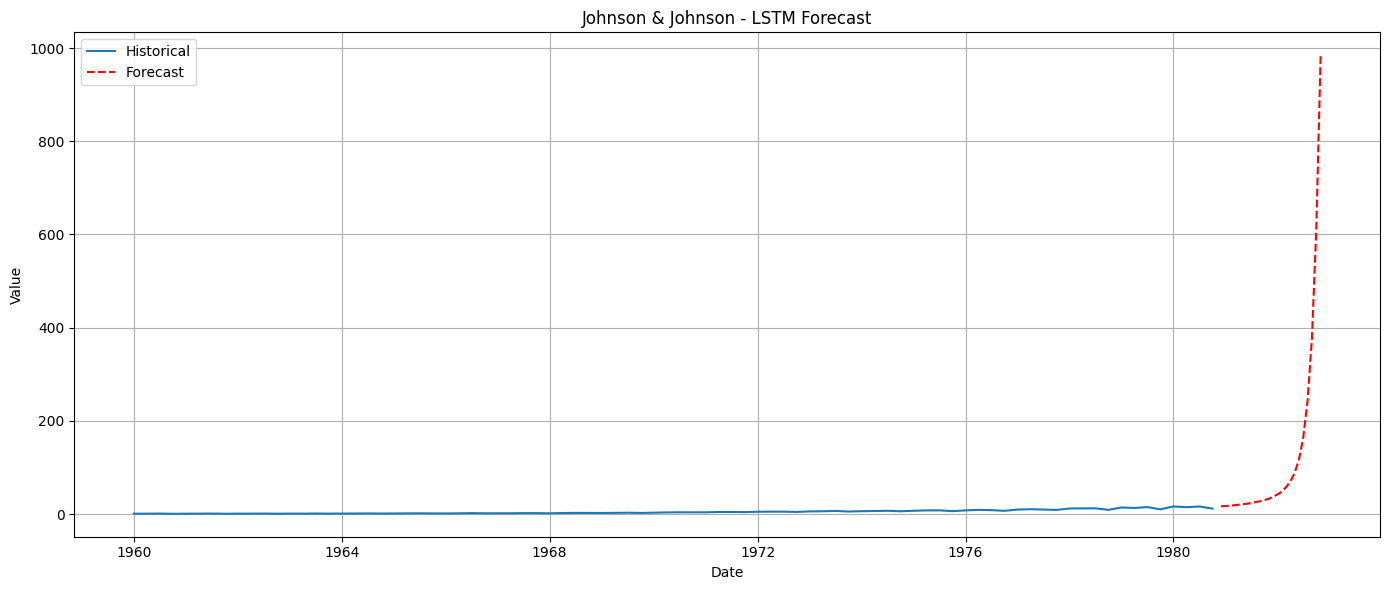

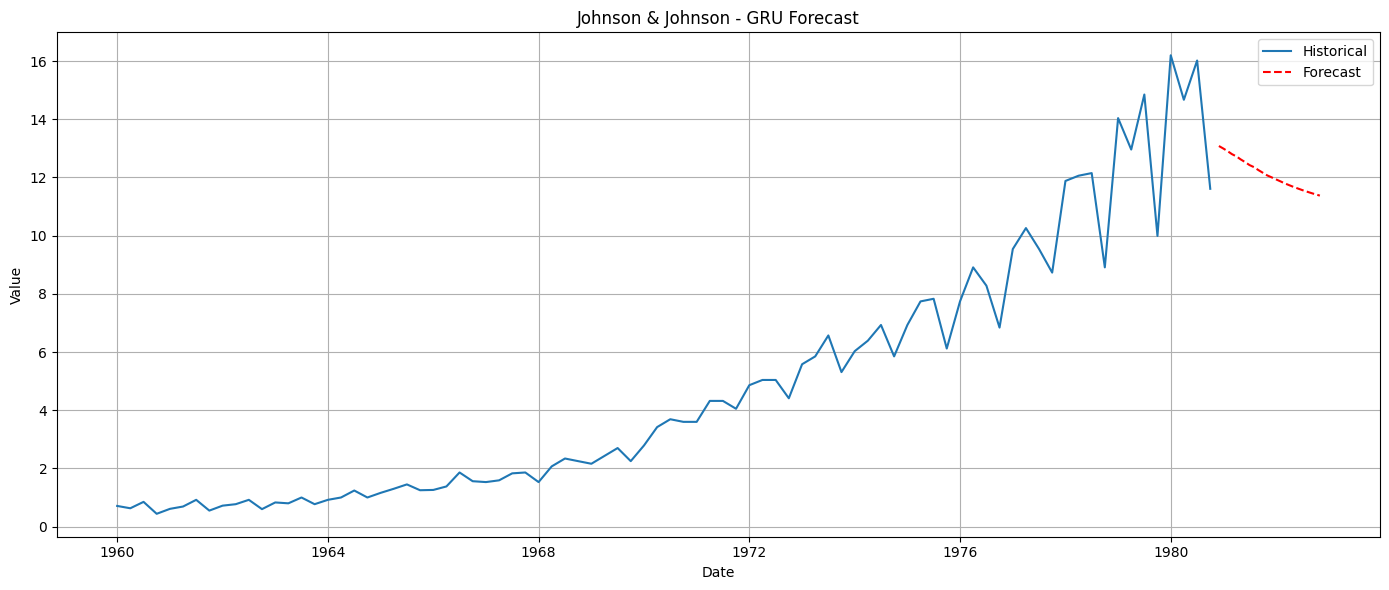

In [ ]:
plot_forecast(johnson_dataset, forecast_lstm_jj, "Johnson & Johnson - LSTM Forecast")
plot_forecast(johnson_dataset, forecast_gru_jj, "Johnson & Johnson - GRU Forecast")